## import

In [ ]:
import json
import numpy as np
import pandas as pd
import folium
from folium import plugins
from folium.features import DivIcon
import matplotlib.pylab as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
import warnings ; warnings.filterwarnings('ignore')

### Read Data

In [ ]:
GJ_pop = pd.read_csv('../2)데이터가공/ProcessedData/인구정보_gwangjin_0430.csv').set_index('행정동')=

In [ ]:
result = pd.read_csv('Data/ProcessedData/gwangjingu_score.csv')
result['행정구역'] = result['행정동'].apply(lambda x: f'광진구 {x}')

In [ ]:
seoul_dong = json.load(open('Data/OneoffData/HangJeongDong_ver20230101.geojson', encoding='utf-8'))
gwangjin = dict(zip(result['행정구역'], [[] for i in range(15)]))

for i in seoul_dong['features']:
    if i['properties']['sggnm']=="광진구":
        gwangjin[i['properties']['temp']].append(np.mean(i['geometry']['coordinates'][0][0], axis=0))

In [ ]:
# 각 값을 조금씩 조정한다.
gwangjin['광진구 군자동'] = [gwangjin['광진구 군자동'][0] + np.array([0,0.002])]
gwangjin['광진구 중곡1동'] = [gwangjin['광진구 중곡1동'][0] + np.array([0,0.002])]
gwangjin['광진구 중곡2동'] = [gwangjin['광진구 중곡2동'][0] + np.array([0.001,0.002])]
gwangjin['광진구 중곡4동'] = [gwangjin['광진구 중곡4동'][0] - np.array([0,0.004])]
gwangjin['광진구 화양동'] = [gwangjin['광진구 화양동'][0] - np.array([0.003,0])]
gwangjin['광진구 자양1동'] = [gwangjin['광진구 자양1동'][0] + np.array([0,0.001])]
gwangjin['광진구 구의1동'] = [gwangjin['광진구 구의1동'][0] + np.array([0.004,0])]
gwangjin['광진구 구의3동'] = [gwangjin['광진구 구의3동'][0] + np.array([0.002,0])]

result = result.merge(pd.DataFrame(gwangjin).T.reset_index().rename(columns={'index':'행정구역',0:'좌표'}), on='행정구역')

## 지수산출식

$$Feature~Importance_{\large{k}} = \frac{Rank_k}{\sum_{j=1}^{N}Rank_j}$$
$$(Rank_k: k\text{번째 변수 회귀계수 절대값의 순위},~ N:\text{변수수})$$

$$Weight_i = \frac{\sum_{k=1}^n Feature~Importance_{ik}}{~\sum_{j=1}^N Feature~Importance_j~}$$
$$(Feature ~Importance_{ik}: i\text{분야의 }k\text{번째 변수의 중요도},~ n: i\text{분야의 변수수},~ N: \text{변수수})$$

## 행정동 별 일반쓰레기위험지수 시각화
- https://github.com/vuski/admdongkor
- https://blog.naver.com/PostView.naver?blogId=slovess1&logNo=222408862138&parentCategoryNo=&categoryNo=7&viewDate=&isShowPopularPosts=true&from=search

In [ ]:
g_map = folium.Map(location = [37.5442, 127.0992], tiles='openstreetmap', zoom_start=13)
g_map.choropleth(geo_data=seoul_dong, data=result, columns=['행정구역', '위험지수_일반쓰레기'], key_on='properties.temp',
                 fill_color='YlGn', fill_opacity=0.8, 
                 line_opacity=0.4, nan_fill_color='darkgray', legend_name='일반쓰레기 위험지수')
# folium.LayerControl(position='topleft').add_to(g_map)

for _, dong, score, xy in result[['행정동','위험지수_일반쓰레기','좌표']].itertuples():
    folium.Marker([xy[1], xy[0]-0.003], icon=DivIcon(html=f'<div style="width:50px; height:50px;font-weight: bold;font-size: 5pt">{dong}\n{np.round(score,3)}</div>')).add_to(g_map)
    
g_map

- 다음년도 일반쓰레기량을 설명하는데 외국인 비율의 영향은 95.0921으로 외국인이 많을수록 쓰레기가 많다고 밝혀졌다.<br>
  자양4동은 외국인 비율이 압도적으로 높으며 조선족, 중국인이 많다.
  - https://www.nocutnews.co.kr/news/5438031
- 다음년도 일반쓰레기량을 설명하는데 점포수가 많을수록 쓰레기 발생이 많다고 밝혀졌다. 군자동은 교통이 편리하며 대학가로 상권이 잘 형성되어 있다.<br>점포수가 많을 뿐 아니라 광진구 행정동 내 매출액 3위로 활성화된 곳이다.  상업 지역이 많아 공간적 제약으로 쓰레기 처리 시설을 마련하기 어려운 경우가 많습니다. 이에 따라 쓰레기 처리 시설이 부족해 일반 쓰레기가 쌓이는 경우가 발생할 수 있습니다. 또한 다가구주택 거래가 많고 아파트 거래는 적은 지역이다. 별도의 쓰레기 수거장을 설립해야 한다.
- 구의3동 역시 점포수가 많고 연매출금액이 높은 지역이다. 상권이 활성화된 지역으로 쓰레기 처리 시설이 부족하나 주택수, 거주인구가 많아 더 심각할 것이다. 광진구 행정동 중 두번째로 인구수가 많다.
- 능동은 다가구주택 거래가 많고 아파트 거래는 적은 지역이다. 별도의 쓰레기 수거장을 설립해야 한다.

### $\blacktriangleright$ 자양 4동
- 외국인비율이 압도적으로 높으며 자료조사 결과 한국계 중국인 및 중국인 거주인구가 서울에서 5번째로 많은 곳임 즉, 중국인들의 쓰레기 배출이 큰 영향을 미쳤을 것이라 판단된다.
- [특정 구역으로의 배출을 독려하는 중국어 표지문구판 설치]<br>
 $\bullet$ 천안녹색소비자연대의 '쓰레기 분리배출 인식조사'에서 19.3%는 안내문이 한글로만 쓰여 있고 그림이나 사진이 없어 이해하기 어렵다고 대답했다.<br>
 $\bullet$ 자양4동에 거주하고 있는 중국인들을 위한 표지문구판 설치
 - https://www.nocutnews.co.kr/news/5438031

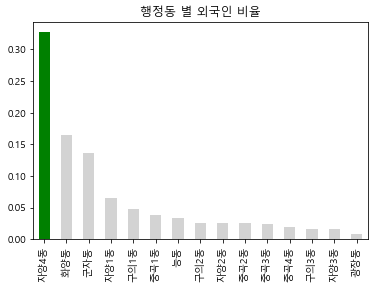

In [3]:
GJ_pop['외국인비율'].sort_values(ascending=False).plot.bar(title="행정동 별 외국인 비율", color=['green']+['lightgray']*14)
plt.xlabel('')
plt.show()

### $\blacktriangleright$ 군자동 
- 세종대학교가 분포해 있어 상권이 매우 활발하고 원룸촌이 발달해 있음 즉, 상업과 주거가 혼합되어 발달되어 있음
- [상업 중심지, 주거 중심지에 스마트 쓰레기통의 설치]<br>
 상업지역과 주거지역은 상이한 쓰레기 발생 시간과 요일 양상을 보이므로 각 지역에 적합한 쓰레기 수거 일정이 구축되어야 함
 그러나 수기적으로 상업지역 사업체들의 의견과 주거지역 주민들의 의견을 수립하고 일정을 구축하기엔 시간과 돈이 많이 들어감
 그러므로 스마트 쓰레기통 즉, 일반쓰레기통에 센서를 부착하여 쓰레기량 및 가득참 정도를 파악할 수 있도록 함으로 인해
 의견수립 없이도 지역 쓰레기 배출 특성을 파악할 수 있다
 파악한 쓰레기 배출 특성을 바탕으로 상업지역과 주거지역에 알맞은 수거일을 정하여 수거할 수 있다
 또한, 불필요하고 효율적이지 못한 수거를 줄일 수 있다
 중심지 예시(상업지역 = 세종대학교 대학가, 주거지역 = 군자원룸촌)